In [23]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
%pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Note: you may need to restart the kernel to use updated packages.


In [25]:
class Value:

    # Children is to build a graph about previous calculations. Parameter given as a tuple
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # Maintain the value of the derivative of L represented by this object Value
        self._backward = lambda: None # Default: this function does not do anything (For example for leaves nodes)
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # Python uses repr funtion to print out value in a specialized way
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    # For python to be able to use + for Value objects
    # # Same as to use: a.__add__(b)
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data + other.data, (self, other), '+')
        
        def _backward(): # Since it is addition, then it will just distribute the grad
            # print('__add__: ', self.label, other.label) 
            self.grad+=1.0 * out.grad # Grads should be aggregated if it is the multivariate case. So for example it has multiple parent nodes
            other.grad+=1.0 * out.grad

        # Sets out's _backward function to the above implemented
        out._backward = _backward
        return out

    def __radd__(self, other): # other + self
        return self + other
    
    # For python to be able to use * for Value objects
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): # Since it is multiplication, then it will null out the either one of them respected
            # print('__mul__: ', self.label, other.label)
            self.grad+=other.data * out.grad
            other.grad+=self.data * out.grad

        out._backward = _backward # We do not need (), because we are just overwriting the function definition of _backward
        return out

    # To be able to do for example 2 * Value(3)
    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __pow__(self, other): # other here is an int or a float
        assert isinstance(other, (int, float)), "only supporting int or float now"
        out = Value(self.data ** other, (self, ), f"**{other}")

        def _backward():
            self.grad=other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'e')

        def _backward():
            self.grad+=math.exp(x) * out.grad # math.exp(x) = out.data

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # print('__tanh__: ', self.label, out.label)
            self.grad+=(1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        # Topological sorting implementation:
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()

In [26]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5, label=)

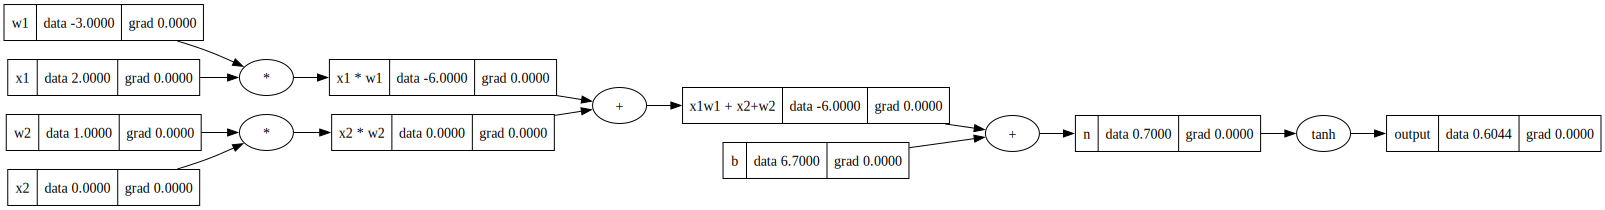

In [27]:
# Inputs:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2:
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neurons:
b = Value(6.7, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1 * w1'
x2w2 = x2 * w2; x2w2.label='x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2+w2'
n = x1w1x2w2 + b; n.label='n'

# Use activation function:
o = n.tanh(); o.label='output'

draw_dot(o)

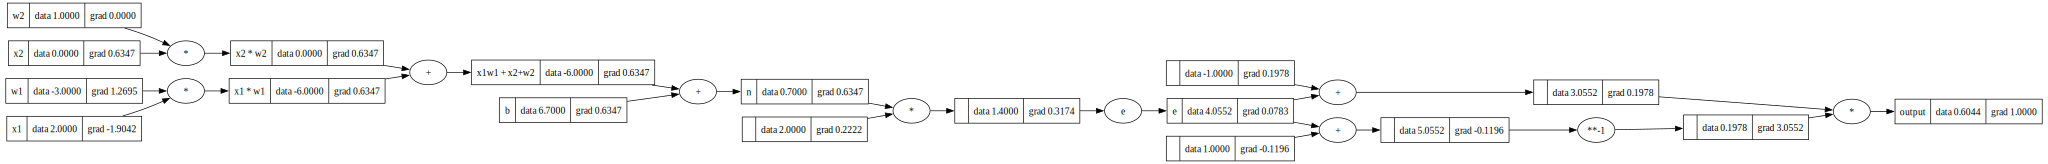

In [28]:
# Let's try out to break tanh to parts:

# Inputs:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2:
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neurons:
b = Value(6.7, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1 * w1'
x2w2 = x2 * w2; x2w2.label='x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2+w2'
n = x1w1x2w2 + b; n.label='n'

# Use activation function:
e = (2*n).exp(); e.label='e'
o = (e - 1) / (e + 1); o.label='output'

o.backward()

draw_dot(o)

In [29]:
# Same thing in pytorch:
import torch

x1 = torch.Tensor([2.0]).double()  ; x1.requires_grad=True # Pytorch autograd does not assume to calculate grad for leave nodes, so it has to be done manually
x2 = torch.Tensor([0.0]).double()  ; x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad=True
w2 = torch.Tensor([1.0]).double()  ; w2.requires_grad=True
b = torch.Tensor([6.7]).double()   ; b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

o

0.6043676560501806
-----
x2 0.6347397363204106
w2 0.0
x1 -1.9042192089612318
w1 1.2694794726408212


tensor([0.6044], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [30]:
class Neuron:
    # nin - number of inputs
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1), label='w') for _ in range(nin)]
        self.b = Value(random.uniform(-1,1), label='b')
        
    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)))as
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        output = act.tanh()
        return output
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    # nout: Number of output, how many neurons are in the layer 
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

# Multi-layer perceptron
class MLP:
    # nouts - list of nout, sizes of all the layers
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    # We need to make sure, when the backward() is happening, the gradient does not add to the previous gradient, that is why we should zero the .grad out before backward()
    # Important!
    def zero_grad(self):
        for p in self.parameters():
            p.grad=0.0

In [31]:
xs = [
    [1.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

In [32]:
network = MLP(3, [4, 4, 1])

In [33]:
# Calculate the loss between the calculated output and the desired output
ypred = [network(x) for x in xs]

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.071500843867986, label=)

In [34]:
ypred

[Value(data=0.4074296912666972, label=),
 Value(data=0.8616350848682103, label=),
 Value(data=0.7973516685090557, label=),
 Value(data=0.8444266617599651, label=)]

In [35]:
loss.backward()

In [36]:
network.layers[0].neurons[0].w[0].grad

0.04168441583724871

In [37]:
network.layers[0].neurons[0].w[0].data

0.8286928846776744

In [38]:
for p in network.parameters():
    p.data += -0.01 * p.grad

In [39]:
network.layers[0].neurons[0].w[0].data

0.8282760405193019

In [40]:
# Recalculate the loss after backward:
ypred = [network(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.971833450694654, label=)

In [41]:
ypred

[Value(data=0.4345478463880275, label=),
 Value(data=0.8551270823103532, label=),
 Value(data=0.7845640190673028, label=),
 Value(data=0.8389655844259734, label=)]

In [42]:
xs = [
    [-1.0, 3.0, -1.0], 
    [-3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, -1.0, -1.0], 
    [-1.0, -3.0, -1.0], 
    [4.0, -3.5, 0.0], 
    [0.5, 1.0, 1.0], 
    [10.0, -10.0, -1.0], 
    [-7.0, 3.0, 4.0], 
    [-3.0, -1.0, 0.5], 
    [1.5, 1.0, 100.0], 
    [1.0, -1.0, -1.0] 
]

ys = [1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0] # Desired targets

network = MLP(12, [4, 4, 1])

for i in range(1000):
    # Forward pass
    ypred = [network(x) for x in xs]
    # Calculate the loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    if i%100==0:
        print(f'{i}. loss', loss)
    # Zero out grads
    network.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters (weights and bias)
    for p in network.parameters():
        p.data += -0.01 * p.grad
    
ypred

0. loss Value(data=21.979415236747492, label=)
100. loss Value(data=0.05784466633110953, label=)
200. loss Value(data=0.023692923652026264, label=)
300. loss Value(data=0.01441303699963433, label=)
400. loss Value(data=0.010213946355362848, label=)
500. loss Value(data=0.00785055709130878, label=)
600. loss Value(data=0.006345946674023424, label=)
700. loss Value(data=0.005308770090140436, label=)
800. loss Value(data=0.004552873613605179, label=)
900. loss Value(data=0.0039788105622143, label=)


[Value(data=0.99384406181019, label=),
 Value(data=-0.988432062974519, label=),
 Value(data=0.9928922022263429, label=),
 Value(data=-0.9814127412257112, label=),
 Value(data=-0.9927731688430385, label=),
 Value(data=0.962300589336623, label=),
 Value(data=0.9928922022263429, label=),
 Value(data=-0.9729207926878258, label=),
 Value(data=0.9854799760499608, label=),
 Value(data=-0.988432062974519, label=),
 Value(data=0.9957954871933753, label=),
 Value(data=-0.9814127412257112, label=)]

In [50]:
test_pred = network([0.0, 0.0000001, -1000])
test_pred

Value(data=-0.9928885028210098, label=)

In [44]:
draw_dot(loss)